# Month to Month Graph of Most Dangerous Streets

Make a chart over time to show how the most dangerous streets have changed over time. 

In [1]:
import pytz
import folium
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from matplotlib._color_data import BASE_COLORS, TABLEAU_COLORS, CSS4_COLORS, XKCD_COLORS

import os
os.chdir('..')

from scripts.crash_data_analysis import CrashDataAnalysis

In [2]:
cda = CrashDataAnalysis()

In [3]:
query = """
with route_centerline_count as (
    select
    sr.gid
    , sr.lrsroute
    , sc.fullname
    , st_AsGeoJSON(sr.geom) as street_line
    , row_number() over (partition by sr.gid, sr.lrsroute order by count(distinct sc.masterid) desc) 
        as fullname_priority

    from street_routes sr
    inner join street_centerline sc using (lrsroute)

    group by 1,2,3,4
)

, crashes_routes as (
    select distinct
    case 
        when sr.gid = 3901 then 3900 -- Speer north
        when sr.gid = 1453 then 1452 -- Speer south
        when sr.gid = 6167 then 6166 -- Marion Parkway
        else sr.gid end as gid
    , c.incident_id
    , to_char(c.reported_date, 'YYYY-MM') as crash_year_month
    , c.sbi
    , c.fatality
    , c.sbi_or_fatality

    from street_routes sr
    inner join crashes c on st_dwithin(sr.geom_denver, c.geom_denver, 25)

    where not at_freeway
    
    -- Exclude this month's crashes
    and to_char(c.reported_date, 'YYYY-MM') < to_char(current_timestamp, 'YYYY-MM')
    
    -- Start on July 1, 2020
    -- and to_char(c.reported_date, 'YYYY-MM') >= '2020-07'
    
    -- Exclude the first pandemic months
    -- and to_char(c.reported_date, 'YYYY-MM') not in ('2020-04', '2020-05', '2020-06')
)

, count_routes as (
    select
    cr.gid
    , sr1.lrsroute
    , st_length(sr1.geom_denver) / 5280 as length_miles
    , cr.crash_year_month
    , count(cr.incident_id) as num_crashes
    , sum(cr.sbi::int) as num_sbi
    , sum(cr.fatality::int) as num_fatality
    , sum(cr.sbi_or_fatality::int) as num_sbi_or_fatality
    
    from crashes_routes cr
    inner join street_routes sr1 using (gid)
    
    group by 1,2,3,4
)

select
count_routes.gid
, rcc.fullname
, rcc.street_line
, count_routes.length_miles
, count_routes.crash_year_month
, count_routes.num_crashes
, count_routes.num_sbi
, count_routes.num_fatality
, count_routes.num_sbi_or_fatality

from count_routes
inner join route_centerline_count rcc on (rcc.gid = count_routes.gid and rcc.fullname_priority = 1)

order by count_routes.gid, count_routes.crash_year_month
"""

In [4]:
# Either pull new data from postgres:
street_month_crashes = pd.read_sql(query, cda.conn)
street_month_crashes.to_csv('data/street_month_crashes.csv', index=False)

# Or read in the CSV:
# street_month_crashes = pd.read_csv('data/street_month_crashes.csv')

In [5]:
# Fill in the data gaps so there is one row per street and month

# todo: make end time the first date of the current month
all_months = pd.DataFrame(
    pd.date_range(start=datetime(2013,1,1), end=datetime(2023,7,1), freq='M').strftime('%Y-%m')
    , columns=['crash_year_month']
)

all_streets = street_month_crashes[['gid', 'fullname', 'street_line', 'length_miles']].drop_duplicates()

all_months_streets = pd.merge(all_months, all_streets, how='cross')

street_month_crashes_all_months = pd.merge(
    all_months_streets
    , street_month_crashes
    , how='left'
    , on=['crash_year_month', 'gid', 'fullname', 'street_line', 'length_miles']
).fillna(0)

In [6]:
median_month_crashes = street_month_crashes_all_months.groupby(
    ['gid', 'fullname']).num_crashes.median().reset_index(name='median_num_crashes')

In [7]:
highest_median_crashes = median_month_crashes.sort_values(by='median_num_crashes', ascending=False).head(30)
highest_median_crashes

,gid,fullname,median_num_crashes
693,1012,E COLFAX AVE,33.0
697,1016,N COLORADO BLVD,31.5
4236,7584,S FEDERAL BLVD,30.0
2726,4689,N FEDERAL BLVD,26.0
2148,3900,N SPEER BLVD,25.5
597,880,N BROADWAY,23.0
3814,6796,W ALAMEDA AVE,21.0
1554,2474,N QUEBEC ST,20.0
2649,4592,S COLORADO BLVD,20.0
3151,5379,W COLFAX AVE,18.0


In [8]:
median_month_crashes[median_month_crashes.gid == 7409]

,gid,fullname,median_num_crashes
4123,7409,S BROADWAY,11.0


In [9]:
list_of_street_gids_to_plot = list(highest_median_crashes['gid'])

## All crashes in Denver by month

When did crash rate stabilize after the pandemic begun? Approx July 1, 2020

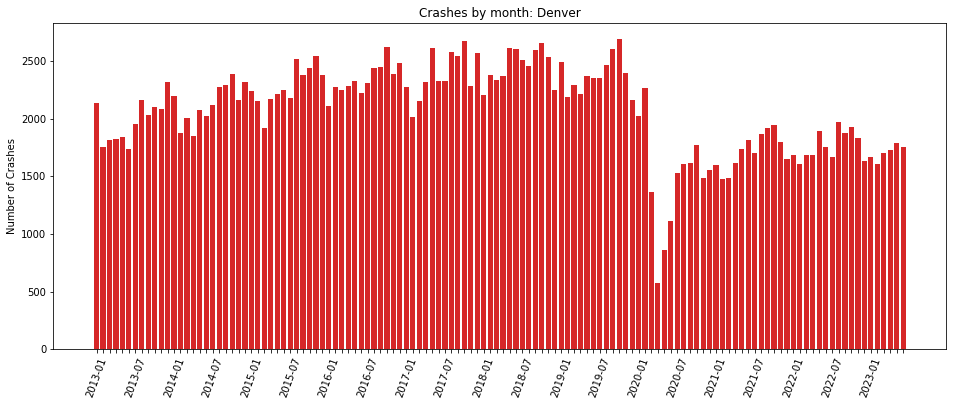

In [10]:
denver_crashes_by_month = street_month_crashes.groupby('crash_year_month').num_crashes.sum()

fig, ax = plt.subplots(figsize=(16,6))

ax.bar(
    x=denver_crashes_by_month.index
    , height=denver_crashes_by_month
    , color=TABLEAU_COLORS['tab:red']
)

ax.tick_params(axis='x', rotation=70)

n = 6  # Keep every Nth label
[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]

plt.ylabel('Number of Crashes')
_ = plt.title(f'Crashes by month: Denver')
# plt.savefig('images/denver_crashes_by_month.png', transparent=False, facecolor='white', bbox_inches='tight')
# denver_crashes_by_month.to_clipboard()

In [11]:
# Calculate how many of the city's crashes take place on each street within each month

street_month_crashes_citywide_in_month = pd.merge(
    street_month_crashes_all_months
    , denver_crashes_by_month.reset_index()
    , how='inner'
    , on='crash_year_month'
    , suffixes=['', '_citywide_in_month']
)

street_month_crashes_citywide_in_month['share_of_city_crashes'] = (
    street_month_crashes_citywide_in_month.num_crashes 
    / street_month_crashes_citywide_in_month.num_crashes_citywide_in_month
)

In [12]:
# Calculate the median share of the city's crashes take place on each street across months

street_month_crashes_median_all_time = pd.merge(
    street_month_crashes_citywide_in_month
    , street_month_crashes_citywide_in_month.groupby('gid').share_of_city_crashes.median().reset_index()
    , how='inner'
    , on='gid'
    , suffixes=['', '_median_all_time']
)

In [13]:
# # Exclude streets with a small number of crashes (but how?)
# (street_month_crashes_median_all_time.share_of_city_crashes_median_all_time > 100 
# / street_month_crashes_median_all_time.num_crashes.sum()).sum()

# len(street_month_crashes_median_all_time)

In [14]:
street_month_crashes_median_all_time['expected_crashes'] = (
    street_month_crashes_median_all_time.share_of_city_crashes_median_all_time
    * street_month_crashes_median_all_time.num_crashes_citywide_in_month
)

In [15]:
street_month_crashes_median_all_time['diff_expected_crashes'] = (
    street_month_crashes_median_all_time.num_crashes - street_month_crashes_median_all_time.expected_crashes
)

In [16]:
street_month_crashes_median_all_time.sort_values(by='diff_expected_crashes')

,crash_year_month,gid,fullname,street_line,length_miles,num_crashes,num_sbi,num_fatality,num_sbi_or_fatality,num_crashes_citywide_in_month,share_of_city_crashes,share_of_city_crashes_median_all_time,expected_crashes,diff_expected_crashes
533818,2019-11,7584,S FEDERAL BLVD,"{""type"":""MultiLineString"",""coordinates"":[[[-10...",4.373528,11.0,0.0,0.0,0.0,2393,0.004597,0.014233,34.060615,-23.060615
533807,2018-12,7584,S FEDERAL BLVD,"{""type"":""MultiLineString"",""coordinates"":[[[-10...",4.373528,15.0,1.0,0.0,1.0,2252,0.006661,0.014233,32.053700,-17.053700
87329,2013-12,1012,E COLFAX AVE,"{""type"":""MultiLineString"",""coordinates"":[[[-10...",5.475202,21.0,0.0,0.0,0.0,2317,0.009063,0.016396,37.988944,-16.988944
87930,2022-01,1016,N COLORADO BLVD,"{""type"":""MultiLineString"",""coordinates"":[[[-10...",5.184503,9.0,0.0,0.0,0.0,1687,0.005335,0.014751,24.885395,-15.885395
87895,2019-02,1016,N COLORADO BLVD,"{""type"":""MultiLineString"",""coordinates"":[[[-10...",5.184503,17.0,1.0,0.0,1.0,2184,0.007784,0.014751,32.216777,-15.216777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87357,2016-04,1012,E COLFAX AVE,"{""type"":""MultiLineString"",""coordinates"":[[[-10...",5.475202,55.0,1.0,0.0,1.0,2283,0.024091,0.016396,37.431488,17.568512
343519,2016-08,4689,N FEDERAL BLVD,"{""type"":""MultiLineString"",""coordinates"":[[[-10...",5.367276,49.0,4.0,0.0,4.0,2442,0.020066,0.012495,30.513232,18.486768
343505,2015-06,4689,N FEDERAL BLVD,"{""type"":""MultiLineString"",""coordinates"":[[[-10...",5.367276,47.0,0.0,0.0,0.0,2246,0.020926,0.012495,28.064177,18.935823
195826,2014-11,2474,N QUEBEC ST,"{""type"":""MultiLineString"",""coordinates"":[[[-10...",5.785164,41.0,3.0,0.0,3.0,2163,0.018955,0.009217,19.935531,21.064469


In [17]:
# last_month = street_month_crashes_median_all_time[
#     street_month_crashes_median_all_time.crash_year_month == '2023-03']

# this_map = folium.Map(prefer_canvas=True, tiles='Stamen Toner')

# good_streets = last_month.sort_values(by='diff_expected_crashes').head(5)['street_line']
# bad_streets = last_month.sort_values(by='diff_expected_crashes').tail(5)['street_line']

# for good_street in good_streets:
#     folium.GeoJson(good_street, style_function=lambda x: {'color': 'green'}).add_to(this_map)

# for bad_street in bad_streets:
#     folium.GeoJson(bad_street, style_function=lambda x: {'color': 'red'}).add_to(this_map)
    
# this_map.fit_bounds(this_map.get_bounds())
# this_map

In [18]:
# last_month.sort_values(by='diff_expected_crashes')

In [19]:
street_month_crashes_median_all_time = street_month_crashes_median_all_time.sort_values(by='crash_year_month')

In [20]:
def plot_one_street_plus_minus(street_gid_to_plot, display_plot=False):
    fig, ax = plt.subplots(figsize=(16,6))

    data_to_plot = street_month_crashes_median_all_time.loc[
        street_month_crashes_median_all_time.gid == street_gid_to_plot
        , ['gid', 'fullname', 'crash_year_month', 'diff_expected_crashes']
    ].copy()

    this_street_name = data_to_plot['fullname'].values[0].title()
    this_street_filename = this_street_name.replace(' ','_')

    data_to_plot['color'] = data_to_plot.diff_expected_crashes.apply(
        lambda x: TABLEAU_COLORS['tab:green'] if x < 0 else TABLEAU_COLORS['tab:red']
    )

    ax.bar(
        x=data_to_plot['crash_year_month']
        , height=data_to_plot['diff_expected_crashes']
        , color=data_to_plot['color']
    )

    ax.tick_params(axis='x', rotation=70)

    n = 6  # Keep every Nth label
    [l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]

    plt.ylabel('Crashes vs Expected Crashes')
    _ = plt.title(f'Number of Crashes Above or Below Expectation: {this_street_name} (gid: {street_gid_to_plot})')

    plt.savefig(
        f'images/streets/crashes_by_month_{this_street_filename}_{street_gid_to_plot}.png'
        , transparent=False, facecolor='white', bbox_inches='tight'
    )
    
    if not display_plot:
        plt.close()

In [21]:
def plot_one_street_expected_marker(street_gid_to_plot):
    fig, ax = plt.subplots(figsize=(16,6))

    data_to_plot = street_month_crashes_median_all_time.loc[
        street_month_crashes_median_all_time.gid == street_gid_to_plot
        , ['gid', 'fullname', 'crash_year_month', 'num_crashes', 'expected_crashes', 'diff_expected_crashes']
    ].copy()

    this_street_name = data_to_plot['fullname'].values[0].title()
    this_street_filename = this_street_name.replace(' ','_')

    data_to_plot['color'] = data_to_plot.diff_expected_crashes.apply(
        lambda x: TABLEAU_COLORS['tab:green'] if x < 0 else TABLEAU_COLORS['tab:red']
    )
    
    data_to_plot['green_bar'] = data_to_plot[['num_crashes', 'expected_crashes']].min(axis=1)

    ax.bar(
        x=data_to_plot['crash_year_month']
        , height=data_to_plot['num_crashes']
        , color=TABLEAU_COLORS['tab:blue']
        , alpha=0.5
    )
    
    ax.scatter(
        x=data_to_plot['crash_year_month']
        , y=data_to_plot['expected_crashes']
        , color='black'
        , marker='_'
    )

    ax.tick_params(axis='x', rotation=70)

    n = 6  # Keep every Nth label
    [l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]

    plt.ylabel('Number of Crashes')
    _ = plt.title(f'Crashes by month: {this_street_name} (gid: {street_gid_to_plot})')

    plt.savefig(
        f'images/streets/marker_crashes_by_month_{this_street_filename}_{street_gid_to_plot}.png'
        , transparent=False, facecolor='white', bbox_inches='tight'
    )
    plt.close()

# plot_one_street_expected_marker(7584)

In [22]:
# for gid in list_of_street_gids_to_plot:
#     plot_one_street_plus_minus(gid)
#     plot_one_street_expected_marker(gid)

In [23]:
# this_street_gid = 125 # E 14th
this_street_gid = 3900 # Speer

In [24]:
street_month_crashes_median_all_time[street_month_crashes_median_all_time.gid == this_street_gid][[
    'crash_year_month', 'num_crashes', 'expected_crashes', 'diff_expected_crashes']].tail(20)

,crash_year_month,num_crashes,expected_crashes,diff_expected_crashes
270754,2021-11,23.0,22.606678,0.393322
270755,2021-12,25.0,20.719643,4.280357
270756,2022-01,20.0,21.222852,-1.222852
270757,2022-02,18.0,20.216433,-2.216433
270758,2022-03,23.0,21.197692,1.802308
270759,2022-04,17.0,21.197692,-4.197692
270760,2022-05,26.0,23.826960,2.173040
270761,2022-06,22.0,22.040567,-0.040567
270762,2022-07,14.0,20.996408,-6.996408
270763,2022-08,23.0,24.795638,-1.795638


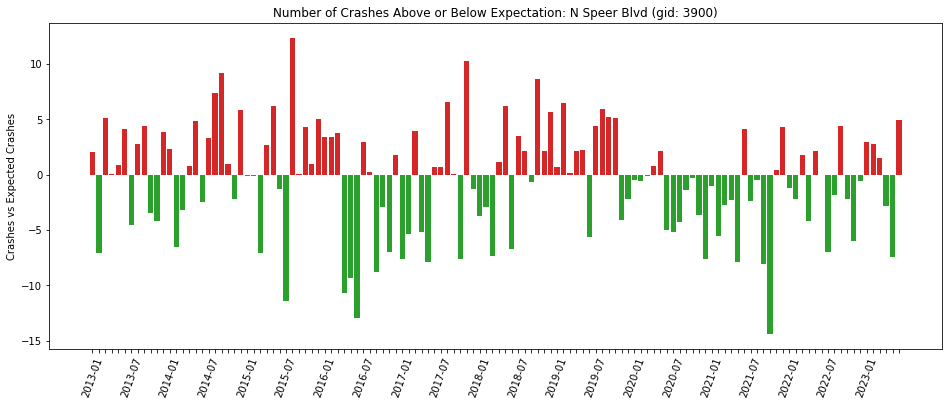

In [25]:
plot_one_street_plus_minus(this_street_gid, display_plot=True)

In [26]:
street_month_crashes_median_all_time[street_month_crashes_median_all_time.gid == this_street_gid].num_crashes.sum()

3228.0

In [27]:
denver_crashes_by_month

crash_year_month
2013-01    2138
2013-02    1753
2013-03    1817
2013-04    1822
2013-05    1837
           ... 
2023-02    1604
2023-03    1704
2023-04    1731
2023-05    1785
2023-06    1750
Name: num_crashes, Length: 126, dtype: int64